In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import Dropout
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


##### Ładowanie danych

In [2]:
def load_and_preprocess(file_path):
    data = pd.read_csv(file_path, parse_dates=['timestamp'])
    data = data.sort_values('timestamp').drop_duplicates('timestamp')
    return data

##### Isolation Forest

In [3]:
def dynamic_isolation_forest(data, column='energy_consumption'):
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Automatyczne szacowanie contamination
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    contamination = max(0.02, len(values[values > (q3 + 1.5 * iqr)]) / len(values))

    model = IsolationForest(contamination=contamination, random_state=42)
    anomalies = model.fit_predict(values)
    data['isolation_forest'] = [1 if x == -1 else 0 for x in anomalies]
    return data

##### LSTM Autoencoder

In [4]:
def lstm_autoencoder(data, column='energy_consumption', window_size=24, iqr_multiplier=1.5):

    # Feature selection and scaling
    scaler = MinMaxScaler()
    values = scaler.fit_transform(data[[column]])

    # Create sliding window sequences
    def create_sequences(data, window_size):
        sequences = []
        for i in range(len(data) - window_size):
            sequences.append(data[i:i + window_size])
        return np.array(sequences)

    X = create_sequences(values, window_size)
    input_dim = X.shape[2]  # Number of features (usually 1)

    # Define LSTM Autoencoder model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(window_size, input_dim), return_sequences=False),
        Dropout(0.2),
        RepeatVector(window_size),
        LSTM(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(input_dim))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X, X, epochs=100, batch_size=32, verbose=0)

    # Predict reconstruction
    pred = model.predict(X)
    mae = np.mean(np.abs(pred - X), axis=(1, 2))  # MAE over sequence and features

    # Calculate IQR-based threshold
    q1 = np.percentile(mae, 25)
    q3 = np.percentile(mae, 75)
    iqr = q3 - q1
    threshold = q3 + iqr_multiplier * iqr
    threshold = np.percentile(mae, 99)

    # Detect anomalies
    anomalies = np.zeros(len(data))
    anomalies[window_size:] = (mae > threshold).astype(int)

    data['lstm_autoencoder'] = anomalies
    return data

##### IQR

In [5]:
def dynamic_iqr(data, column='energy_consumption', window=24):
    data = data.copy()
    data['rolling_median'] = data[column].rolling(window=window).median()
    data['rolling_q1'] = data[column].rolling(window=window).quantile(0.25)
    data['rolling_q3'] = data[column].rolling(window=window).quantile(0.75)
    data['rolling_iqr'] = data['rolling_q3'] - data['rolling_q1']

    data['upper_bound'] = data['rolling_q3'] + 1.5 * data['rolling_iqr']
    data['lower_bound'] = data['rolling_q1'] - 1.5 * data['rolling_iqr']

    data['iqr_method'] = np.where(
        (data[column] > data['upper_bound']) | (data[column] < data['lower_bound']),
        1, 0
    )
    return data

##### Wykresy

In [6]:
def plot_results(data, building_name):
    plt.figure(figsize=(18, 12))

    plt.subplot(3, 1, 1)
    plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue')
    plt.title(f'Zużycie energii w budynku {building_name}')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(data['timestamp'], data['energy_consumption'], label='Zużycie energii', color='blue', alpha=0.3)
    for method, color in zip(['isolation_forest', 'lstm_autoencoder', 'iqr_method'],
                             ['green', 'orange', 'purple']):
        anomalies = data[data[method] == 1]
        plt.scatter(anomalies['timestamp'], anomalies['energy_consumption'],
                    color=color, label=method, alpha=0.5)
    plt.legend()

    plt.subplot(3, 1, 3)
    counts = [data[method].sum() for method in ['isolation_forest', 'lstm_autoencoder', 'iqr_method']]
    plt.bar(['Isolation Forest', 'LSTM Autoencoder', 'IQR'], counts,
            color=['green', 'orange', 'purple'])
    plt.title('Liczba wykrytych anomalii')

    plt.tight_layout()
    plt.show()

##### RUN

C:\Users\Julia\AppData\Local\Temp\ipykernel_1688\2829517793.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2025-01-01", periods=24 * 7, freq="H")
C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\backend\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


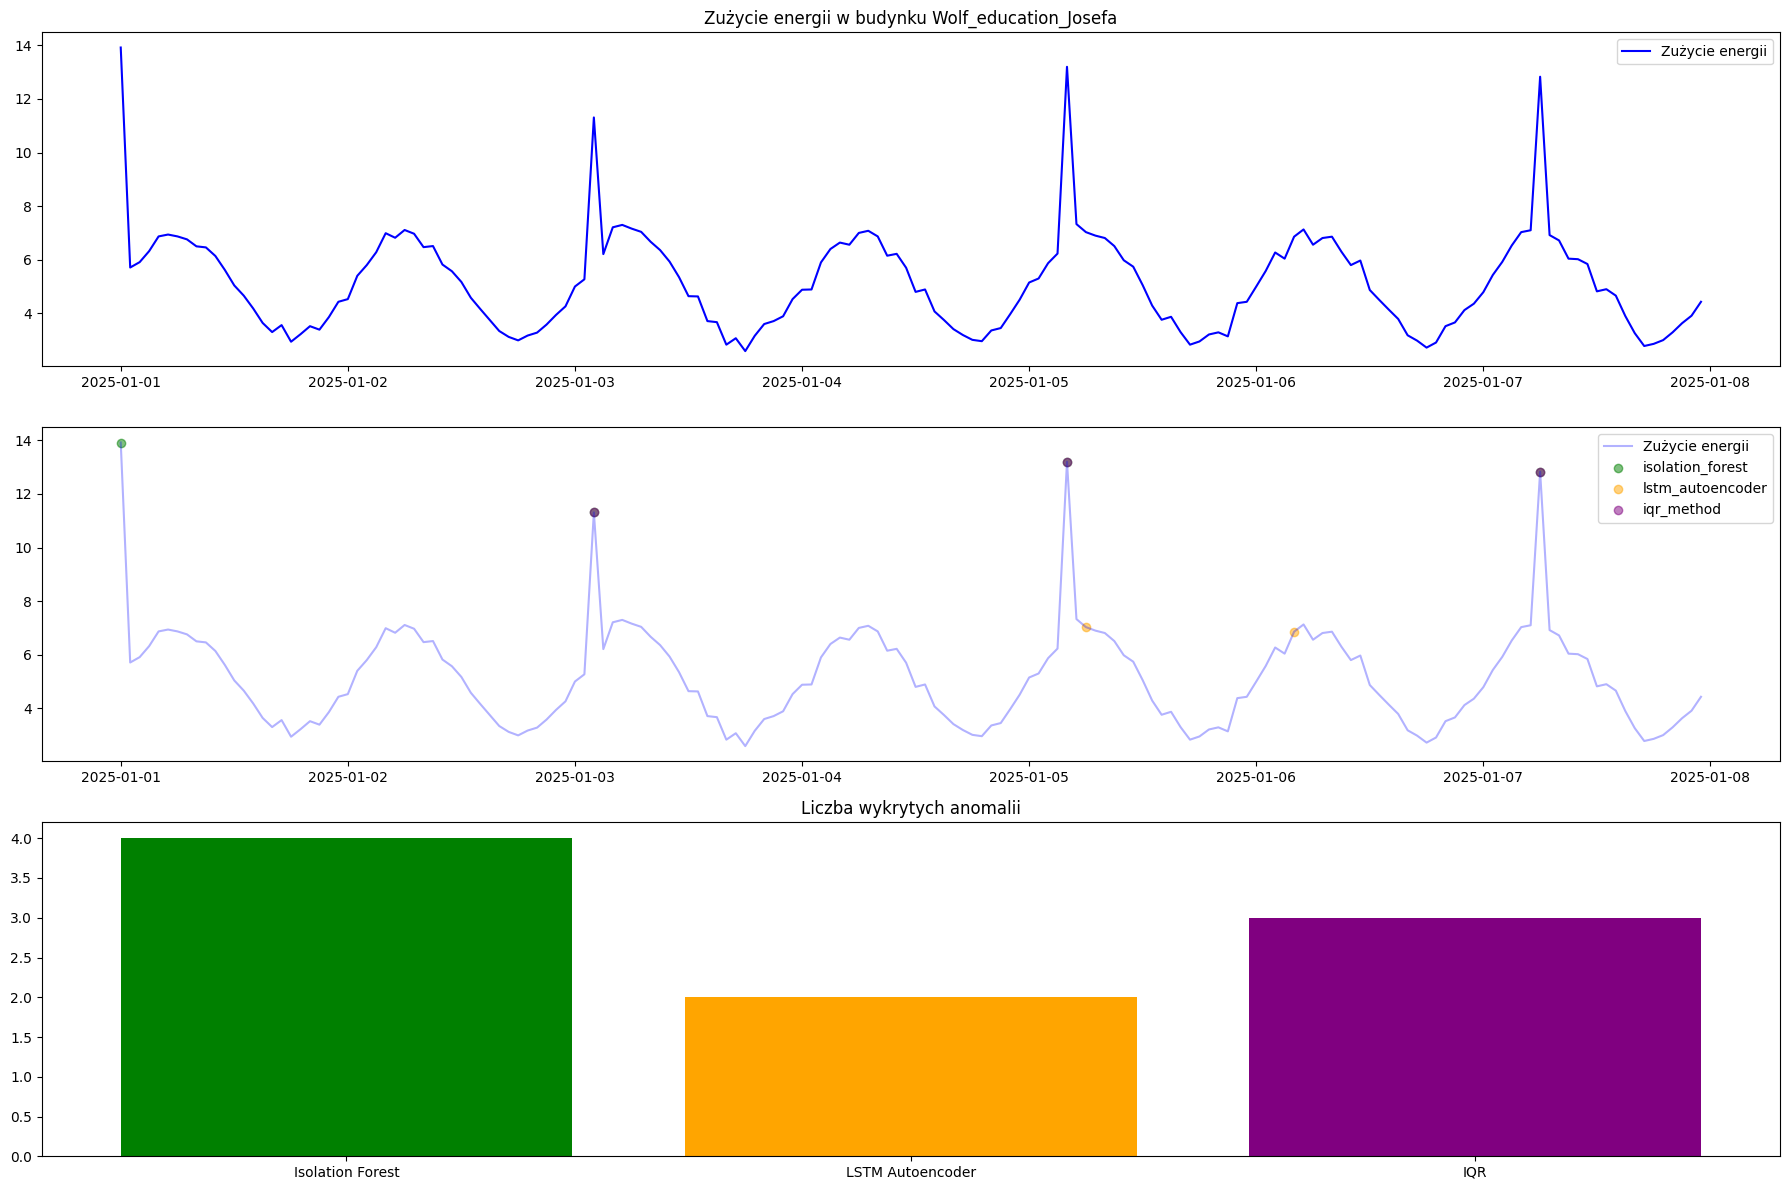

In [7]:
timestamps = pd.date_range(start="2025-01-01", periods=24 * 7, freq="H")

# Generate sinusoidal base pattern
base_signal = 5 + 2 * np.sin(2 * np.pi * timestamps.hour / 24)
noise = np.random.normal(0, 0.2, len(timestamps))
energy = base_signal + noise

# Convert to a mutable array
energy = np.array(energy)

# Insert anomalies at regular intervals
anomalies_indices = np.arange(0, len(energy), 50)
energy[anomalies_indices] += np.random.uniform(5, 10, len(anomalies_indices))

# Create DataFrame
df = pd.DataFrame({
    "timestamp": timestamps,
    "building_id": "Synthetic_Building_001",
    "energy_consumption": np.round(energy, 2),
    "site_id": "Synthetic_Site",
    "sqm": 1000,
    "lat": 50.0614,
    "lng": 19.9366,
    "timezone": "Europe/Warsaw",
    "industry": "Synthetic_Industry",
    "yearbuilt": 2020,
    "numberoffloors": 5,
    "occupants": 50,
    "airTemperature": 20 + 5 * np.sin(2 * np.pi * timestamps.hour / 24)
})

# Przykład użycia
data = load_and_preprocess('one_building_data.csv')
# data = load_and_preprocess('second_building_data.csv')
# data = load_and_preprocess('third_building_data.csv')
data = df

data = dynamic_isolation_forest(data)
data = lstm_autoencoder(data)
data = dynamic_iqr(data)
plot_results(data, 'Wolf_education_Josefa')